<a href="https://colab.research.google.com/github/lorrespz/Transformers-Language-Models--Pytorch-/blob/main/Seq2Seq_LSTM2LSTM_Language_Translation_%5BTensorFlow%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Seq2Seq-LSTM-Translation-[TensorFlow]

This code is from Lazy Programmer's NLP3 course.

In [1]:
import os, sys

from keras.models import Model
from keras.layers import Input, LSTM, GRU, Dense, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import keras.backend as K

In [3]:
# some config
BATCH_SIZE = 64  # Batch size for training.
EPOCHS = 40  # Number of epochs to train for.
LATENT_DIM = 256  # Latent dimensionality of the encoding space.
NUM_SAMPLES = 10000  # Number of samples to train on.
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100



# Dataset: English to Spanish translation

In [4]:
!wget -nc https://lazyprogrammer.me/course_files/nlp3/spa.txt

--2024-03-19 11:24:23--  https://lazyprogrammer.me/course_files/nlp3/spa.txt
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/plain]
Saving to: ‘spa.txt’

spa.txt                 [ <=>                ]   7.45M  --.-KB/s    in 0.1s    

2024-03-19 11:24:23 (49.7 MB/s) - ‘spa.txt’ saved [7817148]



# Process the dataset to create input, target

In [5]:
# Where we will store the data
input_texts = [] # sentence in original language
target_texts = [] # sentence in target language
target_texts_inputs = [] # sentence in target language offset by 1

t = 0
for line in open('spa.txt'):
  # only keep a limited number of samples
  t += 1
  if t > NUM_SAMPLES:
    break

  # input and target are separated by tab
  if '\t' not in line:
    continue

   # split up the input and translation
  input_text, translation, *rest = line.rstrip().split('\t')

  # make the target input and output
  # recall we'll be using teacher forcing
  target_text = translation + ' <eos>'
  target_text_input = '<sos> ' + translation

  input_texts.append(input_text)
  target_texts.append(target_text)
  target_texts_inputs.append(target_text_input)
print("num samples:", len(input_texts))

num samples: 10000


In [6]:
line

"I'm a little shy.\tSoy un poco tímido.\n"

# Tokenize the inputs and outputs

In [8]:
# tokenize the inputs
tokenizer_inputs = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer_inputs.fit_on_texts(input_texts)
input_sequences = tokenizer_inputs.texts_to_sequences(input_texts)
# get the word to index mapping for input language
word2idx_inputs = tokenizer_inputs.word_index
print('Found %s unique input tokens.' % len(word2idx_inputs))

# determine maximum length input sequence
max_len_input = max(len(s) for s in input_sequences)

Found 2494 unique input tokens.


In [9]:
# tokenize the outputs
# don't filter out special characters
# otherwise <sos> and <eos> won't appear
tokenizer_outputs = Tokenizer(num_words=MAX_NUM_WORDS, filters='')
tokenizer_outputs.fit_on_texts(target_texts + target_texts_inputs)
target_sequences = tokenizer_outputs.texts_to_sequences(target_texts)
target_sequences_inputs = tokenizer_outputs.texts_to_sequences(target_texts_inputs)

In [10]:
# get the word to index mapping for output language
word2idx_outputs = tokenizer_outputs.word_index
print('Found %s unique output tokens.' % len(word2idx_outputs))

# store number of output words for later
# remember to add 1 since indexing starts at 1
num_words_output = len(word2idx_outputs) + 1

# determine maximum length output sequence
max_len_target = max(len(s) for s in target_sequences)

Found 6378 unique output tokens.


## Pad the sequences

In [11]:
# pad the sequences
encoder_inputs = pad_sequences(input_sequences, maxlen=max_len_input)
print("encoder_inputs.shape:", encoder_inputs.shape)
print("encoder_inputs[0]:", encoder_inputs[0])

decoder_inputs = pad_sequences(target_sequences_inputs, maxlen=max_len_target, padding='post')
print("decoder_inputs[0]:", decoder_inputs[0])
print("decoder_inputs.shape:", decoder_inputs.shape)

decoder_targets = pad_sequences(target_sequences, maxlen=max_len_target, padding='post')

encoder_inputs.shape: (10000, 6)
encoder_inputs[0]: [ 0  0  0  0  0 18]
decoder_inputs[0]: [   2 2564    0    0    0    0    0    0    0]
decoder_inputs.shape: (10000, 9)


# Load pretrained word vector Glove6B

In [12]:
!wget https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
!unzip -q glove.6B.zip

--2024-03-19 11:30:50--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.01MB/s    in 2m 39s  

2024-03-19 11:33:29 (5.16 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [16]:
# store all the pre-trained word vectors
print('Loading word vectors...')
word2vec = {}
with open(os.path.join('glove.6B.%sd.txt' % EMBEDDING_DIM)) as f:
  # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Loading word vectors...
Found 400000 word vectors.


In [21]:
list(word2vec.keys())[12:20]

['that', 'on', 'is', 'was', 'said', 'with', 'he', 'as']

In [23]:
list(word2vec.items())[12], list(word2vec.values())[12].shape

(('that',
  array([-9.3337e-02,  1.9043e-01,  6.8457e-01, -4.1548e-01, -2.2777e-01,
         -1.1803e-01, -9.5434e-02,  1.9613e-01,  1.7785e-01, -2.0244e-02,
         -5.5409e-02,  3.3867e-01,  7.9396e-01, -4.7126e-02,  4.4281e-01,
         -6.1266e-02,  2.0796e-01,  3.4094e-02, -6.4751e-01,  3.5874e-01,
          1.3936e-01, -6.8310e-01,  2.5596e-01, -1.2911e-01,  2.6080e-01,
         -1.1674e-01,  2.4925e-02, -6.0259e-01, -4.1474e-01, -5.1104e-01,
          1.4936e-01,  7.9977e-01, -1.2716e-01,  4.0474e-01, -2.1435e-01,
          4.7031e-01,  4.9000e-01,  4.8886e-01, -1.7772e-01, -1.8861e-01,
         -7.8391e-01, -1.4158e-01,  2.2169e-01, -2.2078e-01, -3.0509e-01,
         -1.0837e-01,  5.7168e-01, -7.8320e-01, -1.6328e-01, -7.6131e-01,
          8.0873e-02,  6.7217e-04,  4.4713e-01,  1.3434e+00, -2.0014e-01,
         -2.8680e+00, -2.6470e-03, -3.9858e-01,  1.8379e+00,  1.2211e+00,
         -1.6066e-01,  6.5853e-01,  2.6946e-01,  2.7212e-01,  9.4735e-01,
          2.4372e-01,  8.194

In [24]:
# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words = min(MAX_NUM_WORDS, len(word2idx_inputs) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx_inputs.items():
  if i < MAX_NUM_WORDS:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
      embedding_matrix[i] = embedding_vector

Filling pre-trained embeddings...


# Buid the model

In [25]:
# create embedding layer
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=max_len_input,
  # trainable=True
)


In [26]:
# create targets, since we cannot use sparse
# categorical cross entropy when we have sequences
decoder_targets_one_hot = np.zeros(
  (
    len(input_texts),
    max_len_target,
    num_words_output
  ),
  dtype='float32'
)

# assign the values
for i, d in enumerate(decoder_targets):
  for t, word in enumerate(d):
    if word != 0:
      decoder_targets_one_hot[i, t, word] = 1

## Define all the layers of the encoder-decoder

In [27]:
##### build the model #####
encoder_inputs_placeholder = Input(shape=(max_len_input,))
x = embedding_layer(encoder_inputs_placeholder)
encoder = LSTM(
  LATENT_DIM,
  return_state=True,
  # dropout=0.5 # dropout not available on gpu
)
encoder_outputs, h, c = encoder(x)
# encoder_outputs, h = encoder(x) #gru

# keep only the states to pass into decoder
encoder_states = [h, c]
# encoder_states = [state_h] # gru

# Set up the decoder, using [h, c] as initial state.
decoder_inputs_placeholder = Input(shape=(max_len_target,))

# this word embedding will not use pre-trained vectors
# although you could
decoder_embedding = Embedding(num_words_output, EMBEDDING_DIM)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)

# since the decoder is a "to-many" model we want to have
# return_sequences=True
decoder_lstm = LSTM(
  LATENT_DIM,
  return_sequences=True,
  return_state=True,
  # dropout=0.5 # dropout not available on gpu
)
decoder_outputs, _, _ = decoder_lstm(
  decoder_inputs_x,
  initial_state=encoder_states
)

# decoder_outputs, _ = decoder_gru(
#   decoder_inputs_x,
#   initial_state=encoder_states
# )

# final dense layer for predictions
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)


In [28]:
# Create the model object
model = Model([encoder_inputs_placeholder, decoder_inputs_placeholder], decoder_outputs)

# Train the model

In [29]:
def custom_loss(y_true, y_pred):
  # both are of shape N x T x K
  mask = K.cast(y_true > 0, dtype='float32')
  out = mask * y_true * K.log(y_pred)
  return -K.sum(out) / K.sum(mask)


def acc(y_true, y_pred):
  # both are of shape N x T x K
  targ = K.argmax(y_true, axis=-1)
  pred = K.argmax(y_pred, axis=-1)
  correct = K.cast(K.equal(targ, pred), dtype='float32')

  # 0 is padding, don't include those
  mask = K.cast(K.greater(targ, 0), dtype='float32')
  n_correct = K.sum(mask * correct)
  n_total = K.sum(mask)
  return n_correct / n_total

In [30]:
model.compile(optimizer='adam', loss=custom_loss, metrics=[acc])

r = model.fit(
  [encoder_inputs, decoder_inputs], decoder_targets_one_hot,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=0.2,
)

Epoch 1/40
125/125 [==============================] - 31s 210ms/step - loss: 5.9556 - acc: 0.2679 - val_loss: 5.6233 - val_acc: 0.2585
Epoch 2/40
125/125 [==============================] - 8s 61ms/step - loss: 4.9585 - acc: 0.2916 - val_loss: 5.3563 - val_acc: 0.2842
Epoch 3/40
125/125 [==============================] - 7s 59ms/step - loss: 4.5963 - acc: 0.3133 - val_loss: 5.2264 - val_acc: 0.3075
Epoch 4/40
125/125 [==============================] - 6s 49ms/step - loss: 4.3039 - acc: 0.3383 - val_loss: 5.0913 - val_acc: 0.3171
Epoch 5/40
125/125 [==============================] - 3s 28ms/step - loss: 4.0164 - acc: 0.3690 - val_loss: 4.9572 - val_acc: 0.3391
Epoch 6/40
125/125 [==============================] - 3s 27ms/step - loss: 3.7545 - acc: 0.4011 - val_loss: 4.8511 - val_acc: 0.3608
Epoch 7/40
125/125 [==============================] - 4s 36ms/step - loss: 3.5250 - acc: 0.4251 - val_loss: 4.8074 - val_acc: 0.3685
Epoch 8/40
125/125 [==============================] - 4s 35ms/step 

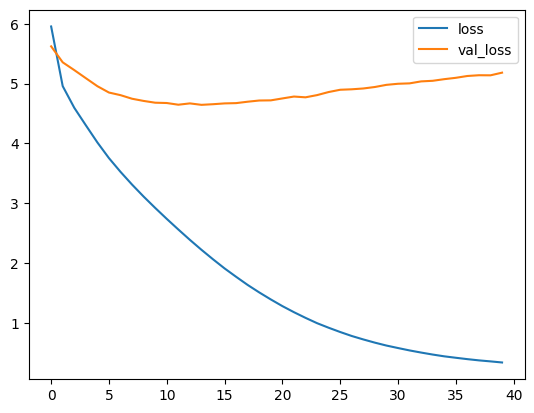

In [32]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()


In [34]:

# accuracies
#plt.plot(r.history['accuracy'], label='acc')
#plt.plot(r.history['val_accuracy'], label='val_acc')
#plt.legend()
#plt.show()

In [38]:
# Save model
model.save('seq2seq_LSTM.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Make predictions

In [ ]:
# TO BE CONTINUED